# Project Overview

**Statement**

Application of Interpretability & Explainability in ML models used to predict who are possible defaulters for the consumer loans product. The data about historic customer behavior is given based on what was provided during loan application. Hence when they acquire new customers they want to predict who is riskier and who is not.

1. **Interpretability**  is linked to the model. A model is said to be interpretable if we can interpret directly the impact of  its parameters on the outcome. E.g. Linear and logistic regression, Lasso and Ridge regressions etc.
     
2. **Explainability** can be applied to any model,specially on black-box models which use decision making algorithms that are not interpretable. Explainability is the extent to which we can interpret the outcome and the internal logic applied in an algorithm. E.g. Decision Tree, Random Forest, XG Boost, Ada Boost etc.


**Objective**  

**The main objective of this project is to explain the interpretability concepts** using Model-Agnostic Interpretable methods Shap (SHapley Additive exPlanations) & LIME (Local Interpretable Model-agnostic Explanations).

In this project we are **not comparing algorithms and different models** based on Accuracy or AUC scores.

**Outcome** 

**This project will showcase how the prediction/conclusion has been predicted by the given ML model** and what are the factors responsible for the given prediction of risk flag on given loan requests.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # Plot charts
import matplotlib.pyplot as plt # Plot charts
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder  # Label encoding
from sklearn.preprocessing import OneHotEncoder # One Hot Encoding
from statsmodels.stats.outliers_influence import variance_inflation_factor #Applying VIF to get feature selection
pd.options.display.max_columns=None 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/list-of-states/List of states by area.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv
/kaggle/input/rbi-data-states-wise-population-incomecsv/RBI DATA states_wise_population_Income.csv


# Dataset Features || Description

1. Income : 	Income of the user
2. Age : 	Age of the user
3. Experience : 	Professional experience of the user in years
4. Profession : 	Profession
5. Married : 	Whether married or single
6. House_ownership : 	Owned or rented or neither
7. Car_ownership : 	Does the person own a car
8. **Risk_flag : 	Defaulted on a loan / The risk_flag indicates whether there has been a default in the past or not**
9. Current_job_years :	Years of experience in the current job
10. Current_house_years : 	Number of years in the current residence
11. City : 	City of residence
12. State : 	State of residence

# Reading dataset files

In the given dataset, city and state as features have been given. Therefore, instead of excluding the feature, thought to add state demographics and explore the effect of State/region in the dataset. Added critical census indicators and merged it with the current dataset to expand the analytical horizon.

In [2]:
ds1 = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv")
ds2 = pd.read_csv("/kaggle/input/rbi-data-states-wise-population-incomecsv/RBI DATA states_wise_population_Income.csv")
ds3 = pd.read_csv("/kaggle/input/list-of-states/List of states by area.csv")

In [3]:
ds1.head(10)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
5,6,6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0
6,7,3954973,58,14,married,rented,no,Librarian,Tiruppur,Tamil_Nadu,8,12,0
7,8,1706172,33,2,single,rented,no,Economist,Jamnagar,Gujarat,2,14,0
8,9,7566849,24,17,single,rented,yes,Flight_attendant,Kota[6],Rajasthan,11,11,0
9,10,8964846,23,12,single,rented,no,Architect,Karimnagar,Telangana,5,13,0


# Data cleaning

In [4]:
ds1.dtypes

Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [5]:
ds1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [6]:
ds1['STATE'].unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

In [7]:
ds1['Rev_State'] = ds1['STATE'].str.replace('_', ' ', regex=True)

In [8]:
ds1.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Madhya Pradesh
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Maharashtra
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Kerala
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Odisha
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Tamil Nadu


In [9]:
ds1['Rev_State'].unique()

array(['Madhya Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra Pradesh',
       'West Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar Pradesh', 'Himachal Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu and Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

In [10]:
ds1['Rev_State'] = ds1['Rev_State'].str.replace('[','', regex=True)
ds1['Rev_State'] = ds1['Rev_State'].str.replace(']', '', regex=True)

In [11]:
ds1['Rev_State'].unique()

array(['Madhya Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra Pradesh',
       'West Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar Pradesh', 'Himachal Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu and Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar Pradesh5', 'Manipur', 'Sikkim'], dtype=object)

In [12]:
ds1['Rev_State'] = ds1['Rev_State'].str.replace('Uttar Pradesh5', 'Uttar Pradesh',regex=True)

In [13]:
ds1['Rev_State'].unique()

array(['Madhya Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra Pradesh',
       'West Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar Pradesh', 'Himachal Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu and Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Manipur', 'Sikkim'], dtype=object)

In [14]:
len(ds1['Rev_State'].unique())

28

In [15]:
ds2.head(10)

,States_Union Territories,2020-21-GSDP,2011-census-LIT-rate,2011-census-POP,2020-21-UNEMP,2011-census-Poverty-rate
0,Andaman and Nicobar Islands,72657400000,86.63,381000,106,1.00
1,Andhra Pradesh,6703215000000,67.02,49581000,60,9.20
2,Arunachal Pradesh,188672400000,65.39,1384000,106,34.67
3,Assam,2284633500000,72.19,31206000,78,31.98
4,Bihar,3857282042000,61.80,104099000,96,33.74
5,Chandigarh,278702500000,86.05,1055000,77,21.81
6,Chhattisgarh,2454516600000,70.28,25545000,63,39.93
7,Delhi,5646692000000,76.24,16788000,63,9.91
8,Goa,533600600000,87.10,1459000,109,5.09
9,Gujarat,12481891200000,86.21,60440000,46,16.63


In [16]:
ds2['States_Union Territories'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka',
       'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
       'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab',
       'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [17]:
len(ds2['States_Union Territories'].unique())

33

In [18]:
ds2.rename(columns = {'States_Union Territories': 'Rev_State'}, inplace = True)

In [19]:
ds2.head(10)

,Rev_State,2020-21-GSDP,2011-census-LIT-rate,2011-census-POP,2020-21-UNEMP,2011-census-Poverty-rate
0,Andaman and Nicobar Islands,72657400000,86.63,381000,106,1.00
1,Andhra Pradesh,6703215000000,67.02,49581000,60,9.20
2,Arunachal Pradesh,188672400000,65.39,1384000,106,34.67
3,Assam,2284633500000,72.19,31206000,78,31.98
4,Bihar,3857282042000,61.80,104099000,96,33.74
5,Chandigarh,278702500000,86.05,1055000,77,21.81
6,Chhattisgarh,2454516600000,70.28,25545000,63,39.93
7,Delhi,5646692000000,76.24,16788000,63,9.91
8,Goa,533600600000,87.10,1459000,109,5.09
9,Gujarat,12481891200000,86.21,60440000,46,16.63


In [20]:
ds3.head(10)

,Rank,State (S) / Union Territory (UT),Area (km2),Region,National share (%)
0,1 (S1),Rajasthan,"3,42,239",Northern,10.41
1,2 (S2),Madhya Pradesh,"3,08,245",Central,9.38
2,3 (S3),Maharashtra,"3,07,713",Western,9.36
3,4 (S4),Uttar Pradesh,"2,40,928",Northern,7.33
4,5 (S5),Gujarat,"1,96,024",Western,5.96
5,6 (S6),Karnataka,"1,91,792",Southern,5.83
6,7 (S7),Andhra Pradesh,"1,62,975",Southern,4.96
7,8 (S8),Odisha,"1,55,707",Eastern,4.74
8,9 (S9),Chhattisgarh,"1,35,191",Central,4.11
9,10 (S10),Tamil Nadu,"1,30,058",Southern,3.96


In [21]:
ds3.rename(columns = {'State (S) / Union Territory (UT)': 'Rev_State'}, inplace = True)

In [22]:
ds3.head(10)

,Rank,Rev_State,Area (km2),Region,National share (%)
0,1 (S1),Rajasthan,"3,42,239",Northern,10.41
1,2 (S2),Madhya Pradesh,"3,08,245",Central,9.38
2,3 (S3),Maharashtra,"3,07,713",Western,9.36
3,4 (S4),Uttar Pradesh,"2,40,928",Northern,7.33
4,5 (S5),Gujarat,"1,96,024",Western,5.96
5,6 (S6),Karnataka,"1,91,792",Southern,5.83
6,7 (S7),Andhra Pradesh,"1,62,975",Southern,4.96
7,8 (S8),Odisha,"1,55,707",Eastern,4.74
8,9 (S9),Chhattisgarh,"1,35,191",Central,4.11
9,10 (S10),Tamil Nadu,"1,30,058",Southern,3.96


In [23]:
ds3['Rev_State'].unique()

array(['Rajasthan', 'Madhya Pradesh', 'Maharashtra', 'Uttar Pradesh',
       'Gujarat', 'Karnataka', 'Andhra Pradesh', 'Odisha', 'Chhattisgarh',
       'Tamil Nadu', 'Telangana', 'Bihar', 'West Bengal',
       'Arunachal Pradesh', 'Jharkhand', 'Assam', 'Ladakh',
       'Himachal Pradesh', 'Uttarakhand', 'Punjab', 'Haryana',
       'Jammu and Kashmir', 'Kerala', 'Meghalaya', 'Manipur', 'Mizoram',
       'Nagaland', 'Tripura', 'Andaman and Nicobar Islands', 'Sikkim',
       'Goa', 'Delhi', 'Dadra and Nagar Haveli and Daman and Diu',
       'Puducherry', 'Chandigarh', 'Lakshadweep'], dtype=object)

In [24]:
len(ds3['Rev_State'].unique())

36

In [25]:
ds4 = pd.merge(ds2,ds3,how = 'left')

In [26]:
ds4.head()

,Rev_State,2020-21-GSDP,2011-census-LIT-rate,2011-census-POP,2020-21-UNEMP,2011-census-Poverty-rate,Rank,Area (km2),Region,National share (%)
0,Andaman and Nicobar Islands,72657400000,86.63,381000,106,1.00,29 (UT3),"8,249",Bay of Bengal,0.251
1,Andhra Pradesh,6703215000000,67.02,49581000,60,9.20,7 (S7),"1,62,975",Southern,4.960
2,Arunachal Pradesh,188672400000,65.39,1384000,106,34.67,14 (S14),"83,743",Northeastern,2.550
3,Assam,2284633500000,72.19,31206000,78,31.98,16 (S16),"78,438",Northeastern,2.390
4,Bihar,3857282042000,61.80,104099000,96,33.74,12 (S12),"94,163",Eastern,2.860


In [27]:
ds4.drop(['Rank','Area (km2)','National share (%)'],axis=1,inplace=True)

In [28]:
ds4['Region'].unique()

array(['Bay of Bengal', 'Southern', 'Northeastern', 'Eastern', 'Northern',
       'Central', 'Western'], dtype=object)

Combining regions ; Eastern + North Eastern + Bay of Bengal = Eastern ; 

In [29]:
ds4.replace(to_replace=["Bay of Bengal","Northeastern"],value="Eastern",inplace = True)

In [30]:
ds4['Region'].unique()

array(['Eastern', 'Southern', 'Northern', 'Central', 'Western'],
      dtype=object)

In [31]:
ds = pd.merge(ds1,ds4,how='left')

In [32]:
ds.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,2020-21-GSDP,2011-census-LIT-rate,2011-census-POP,2020-21-UNEMP,2011-census-Poverty-rate,Region
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern


In [33]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 0 to 251999
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Id                        252000 non-null  int64  
 1   Income                    252000 non-null  int64  
 2   Age                       252000 non-null  int64  
 3   Experience                252000 non-null  int64  
 4   Married/Single            252000 non-null  object 
 5   House_Ownership           252000 non-null  object 
 6   Car_Ownership             252000 non-null  object 
 7   Profession                252000 non-null  object 
 8   CITY                      252000 non-null  object 
 9   STATE                     252000 non-null  object 
 10  CURRENT_JOB_YRS           252000 non-null  int64  
 11  CURRENT_HOUSE_YRS         252000 non-null  int64  
 12  Risk_Flag                 252000 non-null  int64  
 13  Rev_State                 252000 non-null  o

# Creating CSV file of cleaned and merged dataset

In [34]:
ds.to_csv('Loan_prediction_final.csv', index = False)

In [35]:
loan_df = pd.read_csv('/kaggle/working/Loan_prediction_final.csv')

In [36]:
loan_df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,2020-21-GSDP,2011-census-LIT-rate,2011-census-POP,2020-21-UNEMP,2011-census-Poverty-rate,Region
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern


In [37]:
loan_df.drop(['STATE'],axis=1,inplace=True)

In [38]:
loan_df.rename({'Married/Single':'Marital_Status','2020-21-GSDP':'State_GDP','2011-census-LIT-rate':'Literacy_Rate','2011-census-POP':'Population','2020-21-UNEMP':'Unemployment','2011-census-Poverty-rate':'Poverty_Rate'},axis=1,inplace=True)

In [39]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Id                 252000 non-null  int64  
 1   Income             252000 non-null  int64  
 2   Age                252000 non-null  int64  
 3   Experience         252000 non-null  int64  
 4   Marital_Status     252000 non-null  object 
 5   House_Ownership    252000 non-null  object 
 6   Car_Ownership      252000 non-null  object 
 7   Profession         252000 non-null  object 
 8   CITY               252000 non-null  object 
 9   CURRENT_JOB_YRS    252000 non-null  int64  
 10  CURRENT_HOUSE_YRS  252000 non-null  int64  
 11  Risk_Flag          252000 non-null  int64  
 12  Rev_State          252000 non-null  object 
 13  State_GDP          252000 non-null  int64  
 14  Literacy_Rate      252000 non-null  float64
 15  Population         252000 non-null  int64  
 16  Un

In [40]:
loan_df.to_csv('Loan_prediction_final.csv', index = False)

# ***Exploratory Data Analysis,Feature Engineering & Selection***

In [41]:
loan_df.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,2.520000e+05,252000.000000,2.520000e+05,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000,8.300279e+12,75.697066,7.999940e+07,68.703964,20.649930
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438,4.833612e+12,9.507528,5.229446e+07,20.405312,9.513057
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000,1.441739e+11,61.800000,6.110000e+05,30.000000,7.050000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000,5.144000e+12,67.160000,4.197400e+07,47.000000,11.280000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000,6.703215e+12,75.370000,7.214700e+07,65.000000,17.350000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000,1.143873e+13,80.090000,1.040990e+08,80.000000,29.430000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000,1.889307e+13,94.000000,1.998120e+08,133.000000,39.930000


Creating a new feature Per_Capita_Income from given state GDP & Population

In [42]:
loan_df['Per_Capita_Income'] = loan_df['State_GDP']/loan_df['Population']

In [43]:
loan_df.head()

,Id,Income,Age,Experience,Marital_Status,House_Ownership,Car_Ownership,Profession,CITY,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Region,Per_Capita_Income
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central,77727.893208
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western,168126.671650
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern,153984.311202
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern,90882.529661
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern,172646.839092


***Binning of Income & Age Group***

In [44]:
pd.cut(loan_df['Income'],bins=3).value_counts()

(320.372, 3340186.0]      84550
(3340186.0, 6670062.0]    84225
(6670062.0, 9999938.0]    83225
Name: Income, dtype: int64

In [45]:
pd.qcut(loan_df['Income'],q=3).value_counts()

(10309.999, 3318935.0]    84010
(3318935.0, 6647587.0]    84002
(6647587.0, 9999938.0]    83988
Name: Income, dtype: int64

Selecting Quantile Cut for binning income into Low, Medium and High category as cut was generating lopsided skewed bins specially for low category

In [46]:
bin_labels = ['Low','Medium','High']
loan_df['Income_Category'] = pd.qcut(loan_df['Income'],q=3,labels=bin_labels)

In [47]:
loan_df.head()

,Id,Income,Age,Experience,Marital_Status,House_Ownership,Car_Ownership,Profession,CITY,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Region,Per_Capita_Income,Income_Category
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central,77727.893208,Low
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western,168126.671650,High
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern,153984.311202,Medium
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern,90882.529661,Medium
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern,172646.839092,Medium


In [48]:
pd.cut(loan_df['Age'],bins=3).value_counts()

(59.667, 79.0]      85316
(20.942, 40.333]    85149
(40.333, 59.667]    81535
Name: Age, dtype: int64

In [49]:
pd.qcut(loan_df['Age'],q=3).value_counts()

(40.0, 60.0]      86039
(20.999, 40.0]    85149
(60.0, 79.0]      80812
Name: Age, dtype: int64

No substantial difference in bins by cut and qcut so we can select anyone, so continuing with qcut

In [50]:
bin_labels1 = ['Young','Middle-Age','Senior']
loan_df['Age_Group'] = pd.qcut(loan_df['Age'],q=3,labels=bin_labels1)

In [51]:
loan_df.head()

,Id,Income,Age,Experience,Marital_Status,House_Ownership,Car_Ownership,Profession,CITY,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Region,Per_Capita_Income,Income_Category,Age_Group
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central,77727.893208,Low,Young
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western,168126.671650,High,Young
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern,153984.311202,Medium,Senior
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern,90882.529661,Medium,Middle-Age
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern,172646.839092,Medium,Middle-Age


In [52]:
pd.qcut(loan_df['CURRENT_JOB_YRS'],q=3).value_counts()

(-0.001, 4.0]    91504
(4.0, 8.0]       87381
(8.0, 14.0]      73115
Name: CURRENT_JOB_YRS, dtype: int64

In [53]:
bin_labels2 = ['0-4','5-8','9-14']
loan_df['Job_yrs'] = pd.qcut(loan_df['CURRENT_JOB_YRS'],q=3,labels=bin_labels2)

In [54]:
pd.qcut(loan_df['CURRENT_HOUSE_YRS'],q=3).value_counts()

(11.0, 13.0]     102450
(9.999, 11.0]    100547
(13.0, 14.0]      49003
Name: CURRENT_HOUSE_YRS, dtype: int64

In [55]:
pd.qcut(loan_df['CURRENT_HOUSE_YRS'],q=2).value_counts()

(9.999, 12.0]    152338
(12.0, 14.0]      99662
Name: CURRENT_HOUSE_YRS, dtype: int64

In [56]:
loan_df.to_csv('Loan_prediction_final.csv', index = False)

<AxesSubplot:title={'center':'Loan Risk Distribution'}>

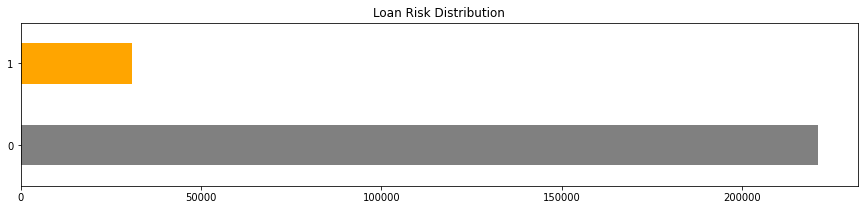

In [57]:
loan_df["Risk_Flag"].value_counts().plot(kind='barh',title='Loan Risk Distribution',color=['grey', 'orange'],figsize=(15,3))

**This shows "How Imbalance is the given data". Hence for further EDA we will move from count based analysis to % share based analysis**

In [58]:
loan_df["Risk_Flag"].value_counts()

0    221004
1     30996
Name: Risk_Flag, dtype: int64

In [59]:
loan_df.groupby("Age_Group").agg({"Age":[min,max]})

Age    
           min max
Age_Group         
Young       21  40
Middle-Age  41  60
Senior      61  79

In [60]:
loan_df.groupby("Income_Category").agg({"Income":[min,max]})

Income         
                     min      max
Income_Category                  
Low                10310  3318935
Medium           3318945  6647587
High             6647986  9999938

In [61]:
loan_df.groupby('Job_yrs').agg({"CURRENT_JOB_YRS":[min,max]})

CURRENT_JOB_YRS    
                    min max
Job_yrs                    
0-4                   0   4
5-8                   5   8
9-14                  9  14

In [62]:
loan_df.groupby(['Risk_Flag','Income_Category','Age_Group']).agg({'Risk_Flag':'count',"Income":[min,max]})

Risk_Flag   Income         
                                         count      min      max
Risk_Flag Income_Category Age_Group                             
0         Low             Young          24811    10675  3318760
                          Middle-Age     24667    11799  3318935
                          Senior         24143    10310  3318761
          Medium          Young          24807  3319389  6646687
                          Middle-Age     25748  3321237  6647354
                          Senior         23468  3319458  6647587
          High            Young          24341  6648155  9999938
                          Middle-Age     25262  6648151  9999400
                          Senior         23757  6648473  9994882
1         Low             Young           3965    10675  3312519
                          Middle-Age      3431    21995  3313586
                          Senior          2993    11114  3318506
          Medium          Young           3344  3318945  6645632
                          Middle-Age      3577  3326988  6641682
                          Senior          3058  3322146  6645326
          High            Young           3881  6648323  9987955
                          Middle-Age      3354  6647986  9994501
                          Senior          3393  6648791  9987812

***Income category wise % share in Risk Flag***

In [63]:
df2 = loan_df.groupby(['Income_Category','Risk_Flag']).agg({'Risk_Flag':'count'})
df3 = df2.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df3))

                           Risk_Flag
Income_Category Risk_Flag           
Low             0               88.0
                1               12.0
Medium          0               88.0
                1               12.0
High            0               87.0
                1               13.0


***Distribution of risk flag (%) by income category***

In [64]:
df2 = loan_df.groupby(['Risk_Flag','Income_Category']).agg({'Risk_Flag':'count'})
df3 = df2.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df3))

                           Risk_Flag
Risk_Flag Income_Category           
0         Low                   33.0
          Medium                33.0
          High                  33.0
1         Low                   34.0
          Medium                32.0
          High                  34.0


It is observed that loan default % is slightly high in high (34%) and low income category (34%) than medium (32%)

[Text(0, 0, '33.3121'),
 Text(0, 0, '33.494'),
 Text(0, 0, '33.194'),
 Text(0, 0, '33.5172'),
 Text(0, 0, '32.1945'),
 Text(0, 0, '34.2883')]

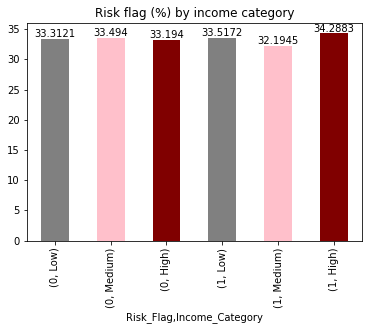

In [65]:
fig = df3['Risk_Flag'].plot(kind='bar', color=['grey', 'pink', 'maroon', 'grey', 'pink','maroon'],title="Risk flag (%) by income category")
fig.bar_label(fig.containers[0], label_type='edge')

*** Distribution of risk flag (%) by Age group***

In [66]:
df4 = loan_df.groupby(['Risk_Flag','Age_Group']).agg({'Risk_Flag':'count'})
df5 = df4.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df5))

                      Risk_Flag
Risk_Flag Age_Group            
0         Young            33.0
          Middle-Age       34.0
          Senior           32.0
1         Young            36.0
          Middle-Age       33.0
          Senior           30.0


It is observed that loan default % is slightly high in young people (36%) followed by Middle-Age(33%) and Senior (30%)

[Text(0, 0, '33.465'),
 Text(0, 0, '34.2424'),
 Text(0, 0, '32.2926'),
 Text(0, 0, '36.1014'),
 Text(0, 0, '33.4301'),
 Text(0, 0, '30.4684')]

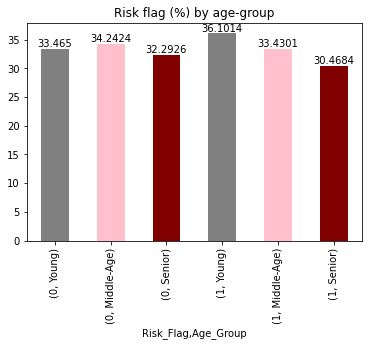

In [67]:
fig = df5['Risk_Flag'].plot(kind='bar', color=['grey', 'pink', 'maroon', 'grey', 'pink','maroon'],title="Risk flag (%) by age-group")
fig.bar_label(fig.containers[0], label_type='edge')

*** Distribution of risk flag (%) by Region***

In [68]:
df6 = loan_df.groupby(['Risk_Flag','Region']).agg({'Risk_Flag':'count'})
df7 = df6.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df7))

                    Risk_Flag
Risk_Flag Region             
0         Central         7.0
          Eastern        26.0
          Northern       25.0
          Southern       27.0
          Western        15.0
1         Central         9.0
          Eastern        28.0
          Northern       24.0
          Southern       26.0
          Western        14.0


In [69]:
loan_df.groupby(['Region']).mean()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Per_Capita_Income
Region,,,,,,,,,,,,,
Central,126441.422087,4.923847e+06,49.523725,10.423034,6.471987,12.033192,0.149866,4.963875e+12,74.283173,6.257396e+07,50.416351,33.417962,81647.749574
Eastern,125803.444343,5.058181e+06,49.969551,10.102814,6.319804,11.983568,0.131548,4.722428e+12,69.732774,7.337640e+07,72.422916,28.488825,70867.669749
Northern,126270.199805,4.903133e+06,50.163288,10.218908,6.367170,12.084276,0.118567,7.687110e+12,79.861036,1.124553e+08,82.546572,20.055541,121107.545776
Southern,126082.120758,5.034367e+06,49.753941,9.855692,6.242977,11.948649,0.116083,8.579600e+12,69.579491,5.304052e+07,62.575565,12.057510,160630.912637
Western,125543.594509,5.009459e+06,50.157181,10.086259,6.405193,11.953395,0.114633,1.691474e+13,91.596204,9.634849e+07,59.137084,17.127826,179972.967781


1. It is observed that loan default % is high in Eastern (28%) and Southern (26%) region. However, it is noteworthy that avg. per-capita income of Eastern region is lowest & Southern region is second highest. 
2. Eastern states have low per capita income which can be a factor contributing to loan default where as Southern state have high population which can be a factor why loan default is high.

***Marital Status wise share (%) in Risk Flag***

In [70]:
df8 = loan_df.groupby(['Risk_Flag','Marital_Status']).agg({'Risk_Flag':'count'})
df9 = df8.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df9))

                          Risk_Flag
Risk_Flag Marital_Status           
0         married              10.0
          single               90.0
1         married               9.0
          single               91.0


[Text(0, 0, '10.4487'),
 Text(0, 0, '89.5513'),
 Text(0, 0, '8.50432'),
 Text(0, 0, '91.4957')]

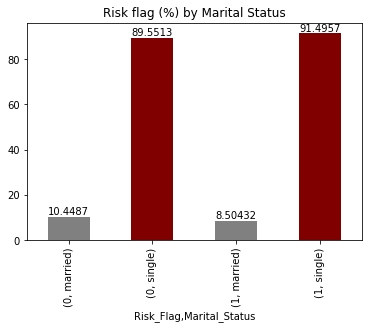

In [71]:
fig = df9['Risk_Flag'].plot(kind='bar', color=['grey', 'maroon', 'grey', 'maroon'],title="Risk flag (%) by Marital Status")
fig.bar_label(fig.containers[0], label_type='edge')

Share of single people defaulting on loan is 91% than married persons (9%). Very skewed data.

***House Ownership wise share (%) in Risk Flag***

In [72]:
df10 = loan_df.groupby(['Risk_Flag','House_Ownership']).agg({'Risk_Flag':'count'})
df11 = df10.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df11))

                           Risk_Flag
Risk_Flag House_Ownership           
0         norent_noown           3.0
          owned                  5.0
          rented                92.0
1         norent_noown           2.0
          owned                  4.0
          rented                94.0


**Share of people in rented house defaulting on loan is 94% than others. Very skewed data.**

[Text(0, 0, '2.9271'),
 Text(0, 0, '5.32027'),
 Text(0, 0, '91.7526'),
 Text(0, 0, '2.30675'),
 Text(0, 0, '3.74242'),
 Text(0, 0, '93.9508')]

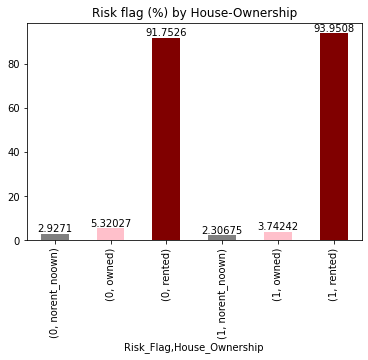

In [73]:
fig = df11['Risk_Flag'].plot(kind='bar', color=['grey', 'pink', 'maroon', 'grey', 'pink','maroon'],title="Risk flag (%) by House-Ownership")
fig.bar_label(fig.containers[0], label_type='edge')

***Car Ownership wise share (%) in Risk Flag***

In [74]:
df12 = loan_df.groupby(['Risk_Flag','Car_Ownership']).agg({'Risk_Flag':'count'})
df13 = df12.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df13))

                         Risk_Flag
Risk_Flag Car_Ownership           
0         no                  69.0
          yes                 31.0
1         no                  73.0
          yes                 27.0


Share of people defaulting on loan who do not have car is 73% than who has. **Highly imbalanced & Skewed data**.

[Text(0, 0, '69.4282'),
 Text(0, 0, '30.5718'),
 Text(0, 0, '72.7868'),
 Text(0, 0, '27.2132')]

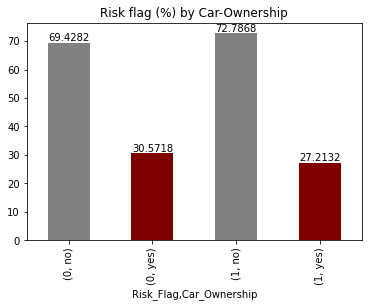

In [75]:
fig = df13['Risk_Flag'].plot(kind='bar', color=['grey', 'maroon', 'grey', 'maroon'],title="Risk flag (%) by Car-Ownership")
fig.bar_label(fig.containers[0], label_type='edge')

In [76]:
df14 = loan_df.groupby(['Risk_Flag','Profession']).agg({'Risk_Flag':'count'})
df15 = df14.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df15))

                                  Risk_Flag
Risk_Flag Profession                       
0         Air_traffic_controller        2.0
          Analyst                       2.0
          Architect                     2.0
          Army_officer                  2.0
          Artist                        2.0
...                                     ...
1         Surveyor                      2.0
          Technical_writer              2.0
          Technician                    2.0
          Technology_specialist         1.0
          Web_designer                  2.0

[102 rows x 1 columns]


In [77]:
df16 = loan_df.groupby(['Risk_Flag','Job_yrs']).agg({'Risk_Flag':'count'})
df17 = df16.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df17))

                   Risk_Flag
Risk_Flag Job_yrs           
0         0-4           36.0
          5-8           35.0
          9-14          29.0
1         0-4           38.0
          5-8           33.0
          9-14          28.0


**Job_Yrs is showing almost similar share in risk distribution as income category**

[Text(0, 0, '36.0229'),
 Text(0, 0, '34.8469'),
 Text(0, 0, '29.1302'),
 Text(0, 0, '38.3662'),
 Text(0, 0, '33.4495'),
 Text(0, 0, '28.1843')]

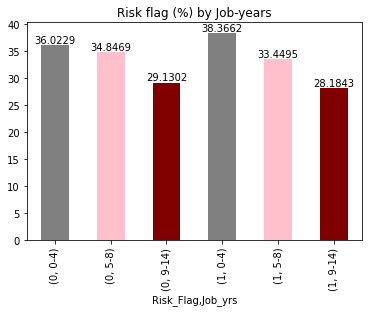

In [78]:
fig = df17['Risk_Flag'].plot(kind='bar', color=['grey', 'pink', 'maroon', 'grey', 'pink','maroon'],title="Risk flag (%) by Job-years")
fig.bar_label(fig.containers[0], label_type='edge')

In [79]:
df18 = loan_df.groupby(['Risk_Flag','CURRENT_HOUSE_YRS']).agg({'Risk_Flag':'count'})
df19 = df18.groupby(level=0).apply(lambda x : 100 * x / float(x.sum()))
print(round(df19))

                             Risk_Flag
Risk_Flag CURRENT_HOUSE_YRS           
0         10                      19.0
          11                      21.0
          12                      21.0
          13                      20.0
          14                      19.0
1         10                      20.0
          11                      21.0
          12                      20.0
          13                      20.0
          14                      19.0


**Risk distribution across current house years is same**

<AxesSubplot:xlabel='Region', ylabel='Per_Capita_Income'>

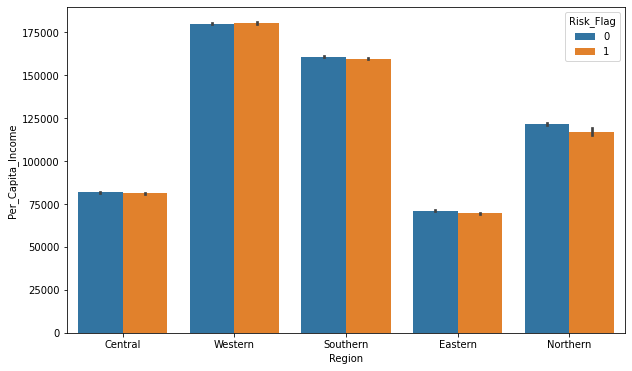

In [80]:
plt.figure(figsize= (10,6))
sns.barplot(x='Region',y='Per_Capita_Income',hue='Risk_Flag',data=loan_df)

<AxesSubplot:xlabel='Region', ylabel='Population'>

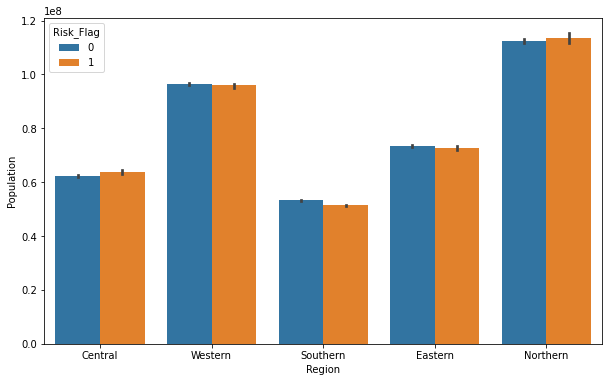

In [81]:
plt.figure(figsize= (10,6))
sns.barplot(x='Region',y='Population',hue='Risk_Flag',data=loan_df)

<AxesSubplot:xlabel='Region', ylabel='Literacy_Rate'>

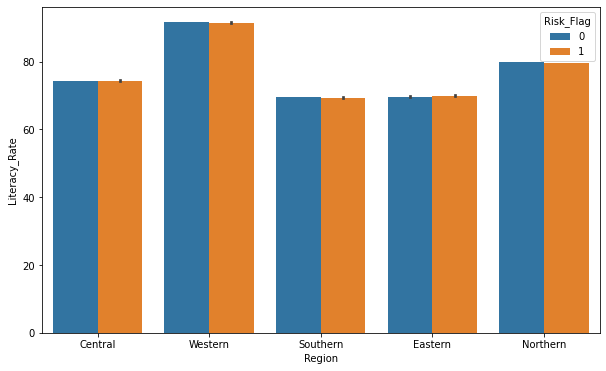

In [82]:
plt.figure(figsize= (10,6))
sns.barplot(x='Region',y='Literacy_Rate',hue='Risk_Flag',data=loan_df)

In [83]:
loan_df.columns

Index(['Id', 'Income', 'Age', 'Experience', 'Marital_Status',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag', 'Rev_State',
       'State_GDP', 'Literacy_Rate', 'Population', 'Unemployment',
       'Poverty_Rate', 'Region', 'Per_Capita_Income', 'Income_Category',
       'Age_Group', 'Job_yrs'],
      dtype='object')

In [84]:
loan_df['Profession'].unique()

array(['Mechanical_engineer', 'Software_Developer', 'Technical_writer',
       'Civil_servant', 'Librarian', 'Economist', 'Flight_attendant',
       'Architect', 'Designer', 'Physician', 'Financial_Analyst',
       'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
       'Surveyor', 'Design_Engineer', 'Chemical_engineer',
       'Hotel_Manager', 'Dentist', 'Comedian', 'Biomedical_Engineer',
       'Graphic_Designer', 'Computer_hardware_engineer',
       'Petroleum_Engineer', 'Secretary', 'Computer_operator',
       'Chartered_Accountant', 'Technician', 'Microbiologist',
       'Fashion_Designer', 'Aviator', 'Psychologist', 'Magistrate',
       'Lawyer', 'Firefighter', 'Engineer', 'Official', 'Analyst',
       'Geologist', 'Drafter', 'Statistician', 'Web_designer',
       'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
       'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
      dtype=object)

Combining similar profession types into 3 categories

In [85]:
Profession_type = {'Mechanical_engineer':'Professional', 'Software_Developer':'Service', 'Technical_writer':'Service',
       'Civil_servant':'Government', 'Librarian':'Service', 'Economist':'Service', 'Flight_attendant':'Service',
       'Architect':'Professional', 'Designer':'Service', 'Physician':'Professional', 'Financial_Analyst':'Service',
       'Air_traffic_controller':'Professional', 'Politician':'Government', 'Police_officer':'Government', 'Artist':'Service',
       'Surveyor':'Service', 'Design_Engineer':'Professional', 'Chemical_engineer':'Professional',
       'Hotel_Manager':'Service', 'Dentist':'Professional', 'Comedian':'Service', 'Biomedical_Engineer':'Professional',
       'Graphic_Designer':'Service', 'Computer_hardware_engineer':'Service',
       'Petroleum_Engineer':'Professional', 'Secretary':'Service', 'Computer_operator':'Service',
       'Chartered_Accountant':'Professional', 'Technician':'Service', 'Microbiologist':'Professional',
       'Fashion_Designer':'Service', 'Aviator':'Professional', 'Psychologist':'Professional', 'Magistrate':'Professional',
       'Lawyer':'Professional', 'Firefighter':'Government', 'Engineer':'Professional', 'Official':'Service', 'Analyst':'Service',
       'Geologist':'Professional', 'Drafter':'Service', 'Statistician':'Professional', 'Web_designer':'Service',
       'Consultant':'Professional', 'Chef':'Service', 'Army_officer':'Government', 'Surgeon':'Professional', 'Scientist':'Professional',
       'Civil_engineer':'Professional', 'Industrial_Engineer':'Professional', 'Technology_specialist':'Service'}

In [86]:
loan_df['Profession_Cat'] = loan_df['Profession'].map(Profession_type)

In [87]:
loan_df['Profession_Cat'].unique()

array(['Professional', 'Service', 'Government'], dtype=object)

# Feature Selection

**Correlation & Heat Map**

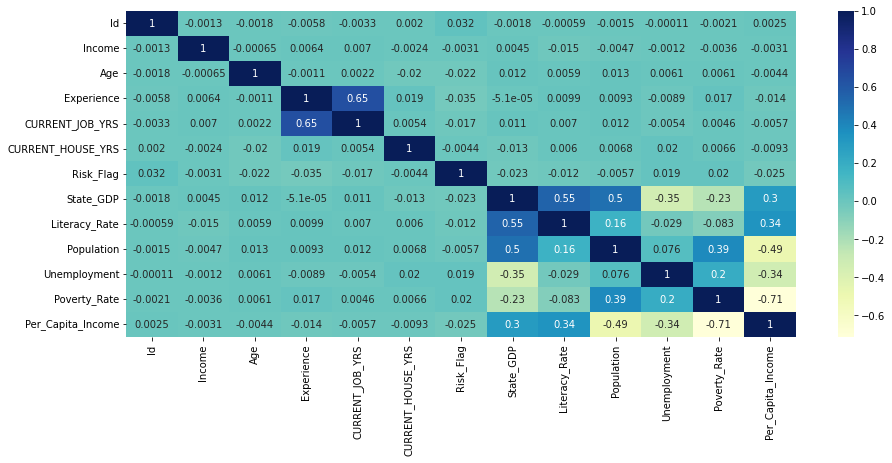

In [88]:
plt.figure(figsize= (15,6))
dataplot = sns.heatmap(loan_df.corr(), cmap="YlGnBu", annot=True)

Experience & Current Job years are highly correlated with each other. Similarly, literacy rate, poverty rate & unemployment has high correlation with per_capita income.

# Variance Inflation Factor (VIF) on features for feature selection

Label encoding & one hot encoding the object data type columns to apply VIF

In [89]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(loan_df[['Region','Profession_Cat']]).toarray())

In [90]:
ohe.categories_

[array(['Central', 'Eastern', 'Northern', 'Southern', 'Western'],
       dtype=object),
 array(['Government', 'Professional', 'Service'], dtype=object)]

In [91]:
ohe_df.columns = ['Central', 'Eastern', 'Northern', 'Southern', 'Western','Government', 'Professional', 'Service']

In [92]:
le = LabelEncoder()

Create a dictionary to map the categories to weightage


In [93]:
house_weightage = {'norent_noown': 0, 'rented': 1, 'owned': 2}
#age_weightage = {'Young': 0, 'Middle-Age': 1, 'Senior': 2}
#income_weightage = {'Low': 0, 'Medium': 1, 'High': 2}
#jobyr_weightage = {'0-4': 0, '5-8': 1, '9-14': 2}

1. Applying encoding only to the categorical variables
2. Although we have applied binning for Age, Income, Job-Year but that has been used for EDA & Feature Engineering
3. Model building will be done using the numerical columns Age, Income & Job-year [Their categorical counterparts i.e. Agre group,Income group and Jobyr group will not be included as features while building the models]

In [94]:
loan_df['Marital_Status1'] = le.fit_transform(loan_df.Marital_Status)
loan_df['Car_Ownership1'] = le.fit_transform(loan_df.Car_Ownership)
#loan_df['House_Ownership1'] = le.fit_transform(loan_df.House_Ownership)
loan_df['House_Ownership1'] =loan_df['House_Ownership'].map(house_weightage)

#loan_df['Age_Group1'] = loan_df['Age_Group'].map(age_weightage)
#loan_df['Income_Category1'] = loan_df['Income_Category'].map(income_weightage)
#loan_df['Job_yrs1'] = loan_df['Job_yrs'].map(jobyr_weightage)

Combining original df with one_hot_encoding df

In [95]:
final_loan_df = loan_df.join(ohe_df)

In [96]:
final_loan_df.head()

,Id,Income,Age,Experience,Marital_Status,House_Ownership,Car_Ownership,Profession,CITY,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Rev_State,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Region,Per_Capita_Income,Income_Category,Age_Group,Job_yrs,Profession_Cat,Marital_Status1,Car_Ownership1,House_Ownership1,Central,Eastern,Northern,Southern,Western,Government,Professional,Service
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,3,13,0,Madhya Pradesh,5645143700000,75.37,72627000,47,31.65,Central,77727.893208,Low,Young,0-4,Professional,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,9,13,0,Maharashtra,18893066600000,94.00,112374000,65,17.35,Western,168126.671650,High,Young,9-14,Service,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,4,10,0,Kerala,5143999900000,66.41,33406000,116,7.05,Southern,153984.311202,Medium,Senior,0-4,Service,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,2,12,1,Odisha,3814703300000,74.43,41974000,78,32.59,Eastern,90882.529661,Medium,Middle-Age,0-4,Service,1,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],3,14,1,Tamil Nadu,12455951500000,75.84,72147000,58,11.28,Southern,172646.839092,Medium,Middle-Age,0-4,Government,1,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Label encoding values for categorical columns (as computed by the model)

1) Marital Status : Single 1 ; Married 0

2) Car ownership : No 0 ; Yes 1

In [97]:
final_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Id                 252000 non-null  int64   
 1   Income             252000 non-null  int64   
 2   Age                252000 non-null  int64   
 3   Experience         252000 non-null  int64   
 4   Marital_Status     252000 non-null  object  
 5   House_Ownership    252000 non-null  object  
 6   Car_Ownership      252000 non-null  object  
 7   Profession         252000 non-null  object  
 8   CITY               252000 non-null  object  
 9   CURRENT_JOB_YRS    252000 non-null  int64   
 10  CURRENT_HOUSE_YRS  252000 non-null  int64   
 11  Risk_Flag          252000 non-null  int64   
 12  Rev_State          252000 non-null  object  
 13  State_GDP          252000 non-null  int64   
 14  Literacy_Rate      252000 non-null  float64 
 15  Population         252000 non-null

In [98]:
loan_df.columns

Index(['Id', 'Income', 'Age', 'Experience', 'Marital_Status',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag', 'Rev_State',
       'State_GDP', 'Literacy_Rate', 'Population', 'Unemployment',
       'Poverty_Rate', 'Region', 'Per_Capita_Income', 'Income_Category',
       'Age_Group', 'Job_yrs', 'Profession_Cat', 'Marital_Status1',
       'Car_Ownership1', 'House_Ownership1'],
      dtype='object')

In [99]:
#final_loan_df.drop(['Id','Marital_Status','House_Ownership','Car_Ownership','Profession', 'CITY','Rev_State','Region','Income_Category','Age_Group', 'Job_yrs', 'Profession_Cat','Central','Government'],axis=1,inplace=True)

final_loan_df.drop(['Id','Marital_Status','House_Ownership','Car_Ownership','Profession', 'CITY','Rev_State','Region','Income_Category','Age_Group', 'Job_yrs', 'Profession_Cat'],axis=1,inplace=True)

final_loan_df.columns

Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'State_GDP', 'Literacy_Rate', 'Population', 'Unemployment',
       'Poverty_Rate', 'Per_Capita_Income', 'Marital_Status1',
       'Car_Ownership1', 'House_Ownership1', 'Central', 'Eastern', 'Northern',
       'Southern', 'Western', 'Government', 'Professional', 'Service'],
      dtype='object')

In [100]:
final_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Income             252000 non-null  int64  
 1   Age                252000 non-null  int64  
 2   Experience         252000 non-null  int64  
 3   CURRENT_JOB_YRS    252000 non-null  int64  
 4   CURRENT_HOUSE_YRS  252000 non-null  int64  
 5   Risk_Flag          252000 non-null  int64  
 6   State_GDP          252000 non-null  int64  
 7   Literacy_Rate      252000 non-null  float64
 8   Population         252000 non-null  int64  
 9   Unemployment       252000 non-null  int64  
 10  Poverty_Rate       252000 non-null  float64
 11  Per_Capita_Income  252000 non-null  float64
 12  Marital_Status1    252000 non-null  int64  
 13  Car_Ownership1     252000 non-null  int64  
 14  House_Ownership1   252000 non-null  int64  
 15  Central            252000 non-null  float64
 16  Ea

In [101]:
X_var = final_loan_df[['Income','Age','Experience','CURRENT_JOB_YRS','CURRENT_HOUSE_YRS','State_GDP', 'Literacy_Rate', 'Population', 'Unemployment','Poverty_Rate','Per_Capita_Income','Marital_Status1','House_Ownership1','Car_Ownership1']]
vif_data = pd.DataFrame()
vif_data["feature"] = X_var.columns
vif_data["VIF"] = [variance_inflation_factor(X_var.values, i) for i in range(len(X_var.columns))]
print(vif_data)

              feature        VIF
0              Income   0.983554
1                 Age   0.956846
2          Experience   1.717350
3     CURRENT_JOB_YRS   1.710097
4   CURRENT_HOUSE_YRS   0.649919
5           State_GDP  14.948671
6       Literacy_Rate   1.567841
7          Population   3.448952
8        Unemployment   1.369883
9        Poverty_Rate   2.287015
10  Per_Capita_Income   3.708729
11    Marital_Status1   0.963371
12   House_Ownership1   0.945213
13     Car_Ownership1   0.999133


1. We will try removing the variables one at a time and check the VIF to check if need to drop further variable
2. Experiance & Current Job Years are higly correlated, let us try removing current job years and checking the VIF

In [102]:
X_var = final_loan_df[['Income','Age','Experience','CURRENT_HOUSE_YRS','State_GDP', 'Literacy_Rate', 'Population', 'Unemployment','Poverty_Rate','Per_Capita_Income','Marital_Status1','House_Ownership1','Car_Ownership1']]
vif_data = pd.DataFrame()
vif_data["feature"] = X_var.columns
vif_data["VIF"] = [variance_inflation_factor(X_var.values, i) for i in range(len(X_var.columns))]
print(vif_data)

              feature        VIF
0              Income   0.983401
1                 Age   0.956542
2          Experience   0.991552
3   CURRENT_HOUSE_YRS   0.648989
4           State_GDP  14.948669
5       Literacy_Rate   1.567245
6          Population   3.448579
7        Unemployment   1.369342
8        Poverty_Rate   2.286783
9   Per_Capita_Income   3.707628
10    Marital_Status1   0.962959
11   House_Ownership1   0.945132
12     Car_Ownership1   0.999020


If trying to remove State_GDP then the VIF for all variables are going exorbitantly high. Similarly by adding One_hot_encoded columns in VIF is also resulting in extremely high VIF values

# Modelling using classification algorithms & Application of Interpretability & Explainability

In the below modelling phase, for each algorithm :-

1. The model will generate its prediction, however the logic behind the prediction is not known as which factor has contributed the most and the magnitude of the contribution. Hence the model is similar to a "Black Box Model"

2. To interpret a model, we need to know :-

   -> Most critical features in the model
   -> For any given case from the model, what is the effect/magniture of each feature in the outcome prediction
   -> Effect of each feature on the entire dataset with their possible predictions

3. We will use SHAP values for the explanability (calculated using SHAP library). Shapley Additive exPlanation (SHAP) is based on the game-theory application to determine contribution of each player in a collaborative game. SHAP explains how much each factor in a model has contributed to the prediction from the calculated baseline Expected value of the model E(X). SHAP summary plot will explain which features are most important and also their magnitude over the entire dataset.

4. For the model with the best explanable SHAP plots, we will deep dive the explainability of the predicted results using Local Shap plot for specific cases along with LIME (Local Interpretable Model-Agnostic Explanations). This will give a comparative analysis for the specific cases by clearly explaining the critical features responsible for the outcome and their contribution.

Dividing dataset into dependent (X) & Independent (Y) variables for model creation and analysis

In [103]:
X = final_loan_df.drop(['Risk_Flag'],axis=1)
y = final_loan_df.Risk_Flag

Dividing the dataset into training & testing as 80 : 20 respectively

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [105]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Fitting of Baseline Model : Logistics Regression

In [210]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
y_train_lr = model.predict(X_train)

**Running diagnostic for both Train and Test cases to understand if there is any underfitting or overfitting**

In [105]:
import sklearn.metrics as metrics
results_train0=[]
for i in range(0,101):
    y_pred = y_pred_lr
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat,zero_division=0)
    precision = metrics.precision_score(y_test, y_hat,zero_division=0)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat,zero_division=0)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10,zero_division=0)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train0.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train0_df = pd.DataFrame(results_train0,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train0_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.0,0.217223,0.933395,0.5,0.121845
1,0.01,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
2,0.02,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
3,0.03,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
4,0.04,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
97,0.97,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
98,0.98,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845
99,0.99,0,0,6141,44259,0.000000,0.0,0.000000,0.000000,0.5,0.121845


In [211]:
import sklearn.metrics as metrics
results_train01=[]
for i in range(0,101):
    y_pred = y_train_lr
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat,zero_division=0)
    precision = metrics.precision_score(y_train, y_hat,zero_division=0)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat,zero_division=0)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10,zero_division=0)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train01.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train01_df = pd.DataFrame(results_train01,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train01_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.0,0.219514,0.934225,0.5,0.123289
1,0.01,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
2,0.02,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
3,0.03,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
4,0.04,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
97,0.97,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
98,0.98,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289
99,0.99,0,0,24855,176745,0.000000,0.0,0.000000,0.000000,0.5,0.123289


# > Interpretation of Logistics Regression Model

1. Logistics regression model uses the logistics function to predict the output probability b/w 0 to 1
2. Since logistics regression model generates a best fit line equation with outcome probabilities and intercept. The generated equation explains if you increase the value of feature by one unit, the estimated odds change by a factor given by the generated equation -> Hence no need to apply interpretablity models (SHAP/LIME) in case of logistics regression.
3. Since Logistics Regression model cannot model interaction between the features, hence we will further analyse using Tree based models. 
4. The AUC score (without any parameter tuning) of Test (0.5) & Train (0.5) for logistics regression model reflects that the dataset with given features require Tree Based Models for prediction due to the variety and complexity of the features.

In [212]:
results__train0_df.to_csv('Loan_prediction_Results0.csv', index = False)

In [213]:
results__train01_df.to_csv('Loan_prediction_Results01.csv', index = False)

# Fitting of Baseline Model : Decision Tree

In [123]:
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier(random_state=0)
model1.fit(X_train, y_train)
y_pred_dtc = model1.predict_proba(X_test)
y_train_dtc = model1.predict_proba(X_train)

As we have seen, the dataset is highly imbalanced and to get best analysis from such dataset, we need probabilistic approach to predictions. Therefore, we will apply Predict_Proba function to generate probability values of the risk flag outcomes

Let us check some test cases to understand the difference between outcomes using Predict (1,0) and Predict Proba (probability of occurence of 1,0 i.e. 0.225, 0.774)

In [215]:
model1.predict_proba(X_test[:5])

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.22580645, 0.77419355]])

In [216]:
model1.predict(X_test[:5])

array([0, 0, 0, 0, 1])

# > Explainability of the Model

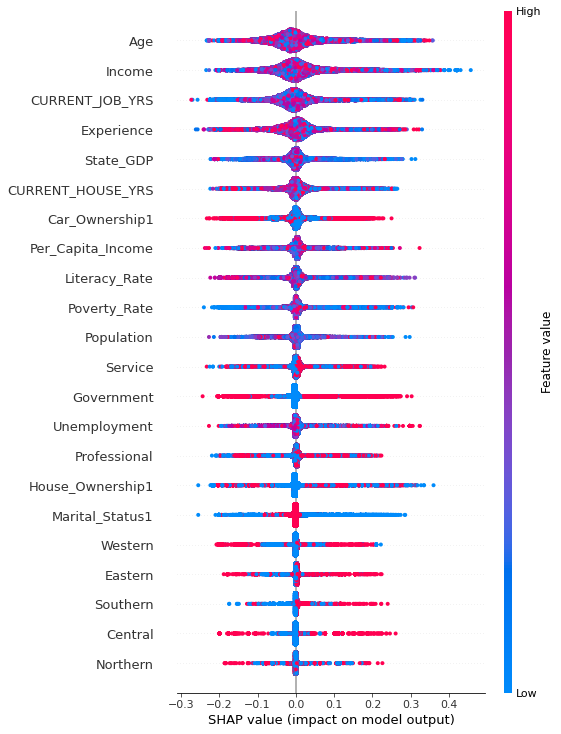

In [217]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model1) # Pass the model object here
shap_values = explainer.shap_values(X_train)
shap_val_df = pd.DataFrame(shap_values[1],columns=X_train.columns)
shap.summary_plot(shap_val_df[X_train.columns].values,X_train,max_display=33)

1. The Shap summary plot explains which features are most important and the magnitude of the effect over the dataset.
2. Each point is representing 1 data point. 
3. Colour Red to Blue represents value of data point from high to low.
4. The x-axis shows the impact of the datapoint on the prediction value. Points towards left are reducing the predictions to the extent of 0.3 whereas points towards right are increasing the predictions to the extent of 0.4. Example low income is reducing the prediction prob value where as high experience is increasing the prediction prob value.

In [124]:
import sklearn.metrics as metrics
results_train=[]
for i in range(0,101):
    y_pred = y_pred_dtc[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train_df = pd.DataFrame(results_train,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.852207,0.400328
1,0.01,5036,5055,1105,39204,0.499059,0.820062,0.620503,0.814872,0.852207,0.400328
2,0.02,5036,5055,1105,39204,0.499059,0.820062,0.620503,0.814872,0.852207,0.400328
3,0.03,5036,5055,1105,39204,0.499059,0.820062,0.620503,0.814872,0.852207,0.400328
4,0.04,5036,5055,1105,39204,0.499059,0.820062,0.620503,0.814872,0.852207,0.400328
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,293,1085,5848,43174,0.212627,0.047712,0.077936,0.048081,0.852207,0.400328
97,0.97,289,1082,5852,43177,0.210795,0.047061,0.076944,0.047425,0.852207,0.400328
98,0.98,289,1082,5852,43177,0.210795,0.047061,0.076944,0.047425,0.852207,0.400328
99,0.99,289,1082,5852,43177,0.210795,0.047061,0.076944,0.047425,0.852207,0.400328


In [126]:
import sklearn.metrics as metrics
results_train1=[]
for i in range(0,101):
    y_pred = y_train_dtc[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train1.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train1_df = pd.DataFrame(results_train1,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train1_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.978067,0.844332
1,0.01,24855,15042,0,161703,0.622979,1.000000,0.767698,0.994044,0.978067,0.844332
2,0.02,24855,15042,0,161703,0.622979,1.000000,0.767698,0.994044,0.978067,0.844332
3,0.03,24855,15042,0,161703,0.622979,1.000000,0.767698,0.994044,0.978067,0.844332
4,0.04,24855,15042,0,161703,0.622979,1.000000,0.767698,0.994044,0.978067,0.844332
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,5839,1,19016,176744,0.999829,0.234923,0.380453,0.236716,0.978067,0.844332
97,0.97,5809,0,19046,176745,1.000000,0.233716,0.378881,0.235502,0.978067,0.844332
98,0.98,5809,0,19046,176745,1.000000,0.233716,0.378881,0.235502,0.978067,0.844332
99,0.99,5809,0,19046,176745,1.000000,0.233716,0.378881,0.235502,0.978067,0.844332


**Interpretation**

1. The features at the top of Shap summary plot are most important. Decision Tree model has considered Age, Income, Current job years, work experience & state GDP as top 5 important features.

2.**** The decision tree shap plot is showing mixed results since there is only 1 tree which is created which may not capture the complex categorical features therefore, we need to run Random Forest model which runs n decision tree and provides optimized results. We will run the model and check the Shap plot.****

4. Additionally, there is stark difference in the Auc score of train & test data indicating Overfitting, hence moving towards Random Forest model.

In [ ]:
results__train_df.to_csv('Loan_prediction_Results.csv', index = False)

In [ ]:
results__train1_df.to_csv('Loan_prediction_Results1.csv', index = False)

# Fitting of Baseline Model : Random Forest Classifier

In [238]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators= 10, criterion="entropy", random_state=0)
model2.fit(X_train, y_train)
y_pred_rfc = model2.predict_proba(X_test)
y_train_rfc = model2.predict_proba(X_train)

# > Interpretability of the Model

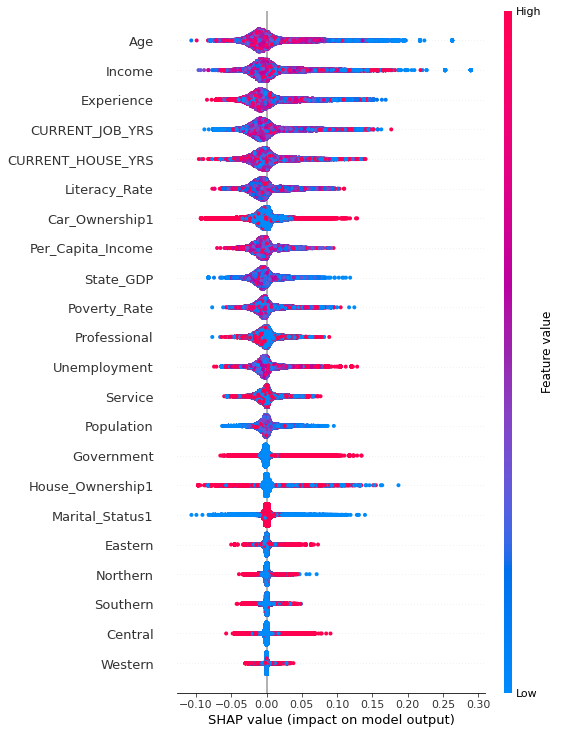

In [295]:
# import shap
# explainer = shap.TreeExplainer(model2) # Pass the model object here
# shap_values = explainer.shap_values(X_train)
# shap_val_df = pd.DataFrame(shap_values[1],columns=X_train.columns)
# shap.summary_plot(shap_val_df[X_train.columns].values,X_train,max_display=33)

In [239]:
import sklearn.metrics as metrics
results_train2=[]
for i in range(0,101):
    y_pred = y_pred_rfc[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train2.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train2_df = pd.DataFrame(results_train2,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train2_df)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.92056,0.574813
1,0.01,5903,8652,238,35607,0.405565,0.961244,0.570448,0.948379,0.92056,0.574813
2,0.02,5903,8646,238,35613,0.405732,0.961244,0.570614,0.948388,0.92056,0.574813
3,0.03,5901,8630,240,35629,0.406097,0.960918,0.570917,0.948094,0.92056,0.574813
4,0.04,5894,8593,247,35666,0.406848,0.959779,0.571456,0.947035,0.92056,0.574813
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,4,3,6137,44256,0.571429,0.000651,0.001301,0.000658,0.92056,0.574813
97,0.97,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.92056,0.574813
98,0.98,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.92056,0.574813
99,0.99,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.92056,0.574813


In [240]:
import sklearn.metrics as metrics
results_train3=[]
for i in range(0,101):
    y_pred = y_train_rfc[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train3.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train3_df = pd.DataFrame(results_train3,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train3_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.9742,0.794053
1,0.01,24855,26909,0,149836,0.480160,1.000000,0.648795,0.989394,0.9742,0.794053
2,0.02,24855,26889,0,149856,0.480346,1.000000,0.648964,0.989402,0.9742,0.794053
3,0.03,24855,26811,0,149934,0.481071,1.000000,0.649626,0.989433,0.9742,0.794053
4,0.04,24855,26623,0,150122,0.482828,1.000000,0.651226,0.989506,0.9742,0.794053
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,199,1,24656,176744,0.995000,0.008006,0.015885,0.008086,0.9742,0.794053
97,0.97,167,0,24688,176745,1.000000,0.006719,0.013348,0.006786,0.9742,0.794053
98,0.98,159,0,24696,176745,1.000000,0.006397,0.012713,0.006461,0.9742,0.794053
99,0.99,158,0,24697,176745,1.000000,0.006357,0.012633,0.006420,0.9742,0.794053


**Interpretation**

1. The features at the top of Shap summary plot are most important. Random Forest model has considered Age, Income, work experience, Current job years & Current house years as top 5 important features.

2.**** The Random Forest shap plot is clearer than decision tree model, however, still there are mixed signals for some features which could not clearly show the impact on the prediction probabilities. Hence, we need to run XG Boost classifier model and check the outcomes and shap plot.****

4. Though the Auc score of train & test data is 0.97 and 0.92 which is showing this as a good model, However, we will not consider this model as the SHAP plot is not indicating clear Explanability. ****As mentioned earlier our aim is not to select model with highest AUC score but a model with acceptable AUC score and good explainability. ****

In [241]:
results__train2_df.to_csv('Loan_prediction_Results2.csv', index = False)

In [242]:
results__train3_df.to_csv('Loan_prediction_Results3.csv', index = False)

# Fitting of Baseline Model : XG Boost Classifier

In [127]:
import xgboost as xgb
model3 = xgb.XGBClassifier(learning_rate = 0.1,alpha = 10, random_state=0)
model3.fit(X_train, y_train)
y_pred_xgbc = model3.predict_proba(X_test)
y_train_xgbc = model3.predict_proba(X_train)

# > Interpretability of the Model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


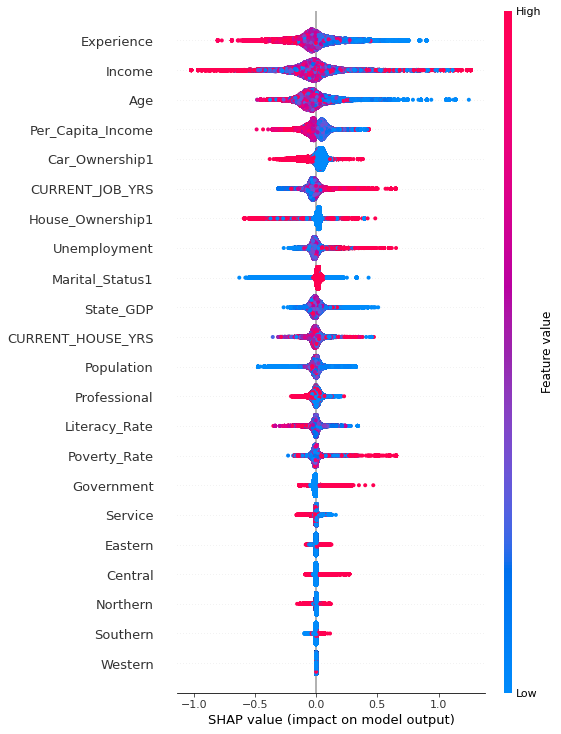

In [321]:
import shap
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_train)
shap_val_df2 = pd.DataFrame(shap_values,columns=X_train.columns)
shap.summary_plot(shap_val_df2[X_train.columns].values,X_train,max_display=33)

In [129]:
import sklearn.metrics as metrics
results_train4=[]
for i in range(0,101):
    y_pred = y_pred_xgbc[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train4.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train4_df = pd.DataFrame(results_train4,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train4_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.806612,0.4271
1,0.01,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.806612,0.4271
2,0.02,6141,44245,0,14,0.121879,1.000000,0.217277,0.933415,0.806612,0.4271
3,0.03,6137,44113,4,146,0.122129,0.999349,0.217659,0.932998,0.806612,0.4271
4,0.04,6134,43710,7,549,0.123064,0.998860,0.219130,0.933112,0.806612,0.4271
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.806612,0.4271
97,0.97,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.806612,0.4271
98,0.98,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.806612,0.4271
99,0.99,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.806612,0.4271


In [130]:
import sklearn.metrics as metrics
results_train5=[]
for i in range(0,101):
    y_pred = y_train_xgbc[:,1]
    #y_hat = [1 if (pred >= i/100).any() else 0 for pred in y_pred]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train5.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train5_df = pd.DataFrame(results_train5,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train5_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.828821,0.465645
1,0.01,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.828821,0.465645
2,0.02,24855,176660,0,85,0.123341,1.000000,0.219596,0.934254,0.828821,0.465645
3,0.03,24855,176048,0,697,0.123716,1.000000,0.220192,0.934467,0.828821,0.465645
4,0.04,24848,174317,7,2428,0.124761,0.999718,0.221837,0.934809,0.828821,0.465645
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.828821,0.465645
97,0.97,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.828821,0.465645
98,0.98,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.828821,0.465645
99,0.99,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.828821,0.465645


**Interpretation**

1. The features at the top of Shap summary plot are most important. XG Boost model has considered Work experience, Age, Income, per capita income & car ownership as top 5 important features.

2.**** The XG Boost shap plot is showing a clear explainable plot.****

3.The Auc score of train & test data is 0.82 and 0.80, However,the SHAP plot is indicating clear Explanability of the reason behind the predictions. ****Hence we will Go-Ahead with XG Boost model for the predictions for the case. However, we will remove the least contributing features to run XG Boost model again ****

In [301]:
results__train4_df.to_csv('Loan_prediction_Results4.csv', index = False)

In [302]:
results__train5_df.to_csv('Loan_prediction_Results5.csv', index = False)

# > Model Iteration 2 : Excluding the feature "Region" - as shown in Shap Plots, the regions have almost no effect on the models

In [106]:
X = final_loan_df.drop(['Risk_Flag','Southern','Western','Northern','Central','Eastern'],axis=1)
y = final_loan_df.Risk_Flag

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

**Iteration 2 : XG Boost Classifier**

In [108]:
import xgboost as xgb
model4 = xgb.XGBClassifier(learning_rate = 0.1,alpha = 10, random_state=0)
model4.fit(X_train, y_train)
y_pred_xgbc1 = model4.predict_proba(X_test)
y_train_xgbc1 = model4.predict_proba(X_train)

**Generating Y_Pred for the dataset to select specific cases for explaining SHAP at local level. We have already explained SHAP at global level using SHAP summary plot**

In [130]:
z = final_loan_df.drop(['Southern','Western','Northern','Central','Eastern'],axis=1)

In [132]:
y_pred_xgbc_iter2 = model4.predict_proba(X)
y_pred_xgbc_iter2_df = pd.DataFrame(y_pred_xgbc_iter2)
xgbdf_out = pd.merge(z, y_pred_xgbc_iter2_df, how = 'left', left_index = True, right_index = True)

In [133]:
xgbdf_out.to_csv('XGB_loan_prediction_Result.csv', index = True)

In [226]:
import sklearn.metrics as metrics
results_train6=[]
for i in range(0,101):
    y_pred = y_pred_xgbc1[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train6.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train6_df = pd.DataFrame(results_train6,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train6_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.8088,0.432608
1,0.01,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.8088,0.432608
2,0.02,6141,44252,0,7,0.121862,1.000000,0.217250,0.933405,0.8088,0.432608
3,0.03,6138,44205,3,54,0.121924,0.999511,0.217336,0.933019,0.8088,0.432608
4,0.04,6133,43815,8,444,0.122788,0.998697,0.218688,0.932814,0.8088,0.432608
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.8088,0.432608
97,0.97,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.8088,0.432608
98,0.98,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.8088,0.432608
99,0.99,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.8088,0.432608


In [228]:
import sklearn.metrics as metrics
results_train7=[]
for i in range(0,101):
    y_pred = y_train_xgbc1[:,1]
    #y_hat = [1 if (pred >= i/100).any() else 0 for pred in y_pred]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train7.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train7_df = pd.DataFrame(results_train7,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train7_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.830057,0.470188
1,0.01,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.830057,0.470188
2,0.02,24855,176718,0,27,0.123305,1.000000,0.219540,0.934234,0.830057,0.470188
3,0.03,24854,176473,1,272,0.123451,0.999960,0.219770,0.934282,0.830057,0.470188
4,0.04,24851,174801,4,1944,0.124472,0.999839,0.221383,0.934752,0.830057,0.470188
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.830057,0.470188
97,0.97,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.830057,0.470188
98,0.98,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.830057,0.470188
99,0.99,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.830057,0.470188


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


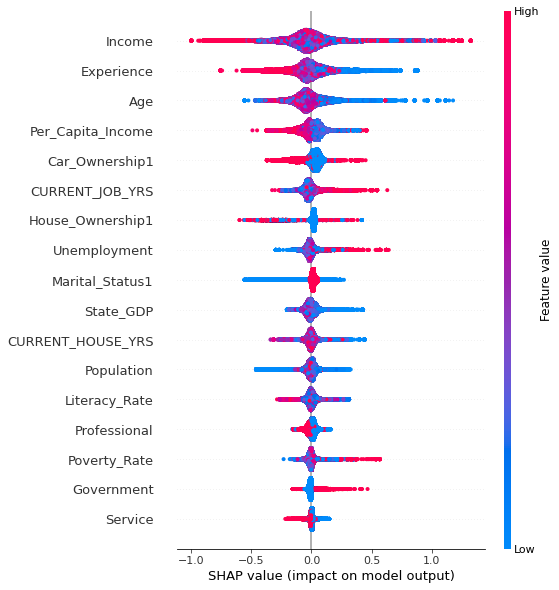

In [110]:
import shap
explainer = shap.TreeExplainer(model4)
shap_values = explainer.shap_values(X_train)
shap_val_df3 = pd.DataFrame(shap_values,columns=X_train.columns)
shap.summary_plot(shap_val_df3[X_train.columns].values,X_train,max_display=33)

**Interpretation**

1. The features at the top of Shap summary plot are most important. XG Boost model (iteration-2) has considered Income, Work experience, Age, per capita income & car ownership as top 5 important features.

2.**** The XG Boost (iter-2) shap plot is very aptly showcasing the Explainability of the black-box model.****

3.The Auc score of train & test data is 0.82 and 0.80, However,the SHAP plot is indicating clear Explanability of the reason behind the predictions. ****Hence we will Go-Ahead with XG Boost model for the predictions for the case. However, we will remove the least contributing features to run XG Boost model again ****

In [114]:
import shap
explainer = shap.TreeExplainer(model4)
shap_values = explainer(X)

Running SHAP Waterfall chart for specific case of index no. 2406 and 234595

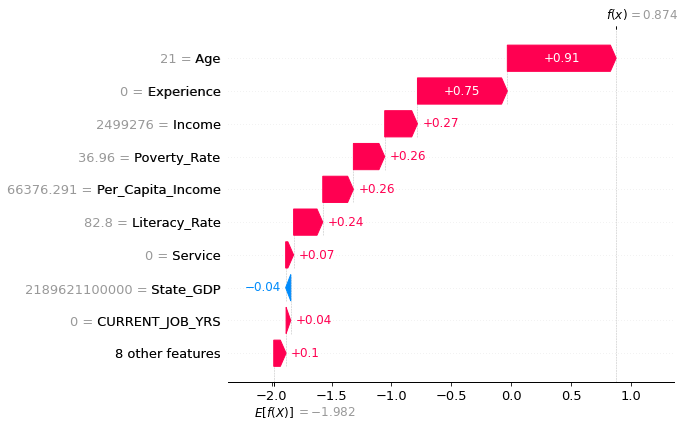

In [137]:
shap.plots.waterfall(shap_values[2406], max_display=10) # Risk Flag : 1

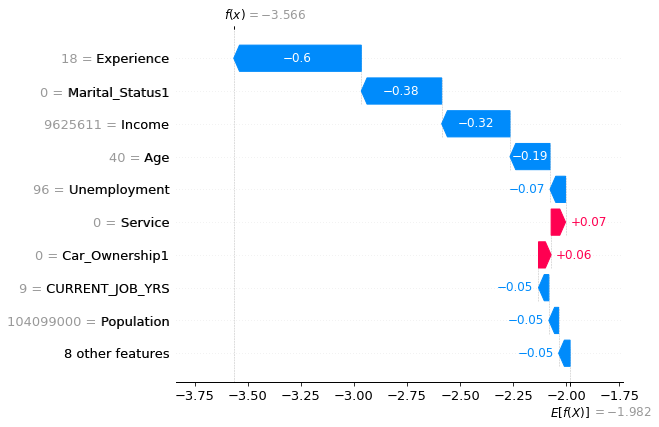

In [136]:
shap.plots.waterfall(shap_values[217449], max_display=10) # Risk Flag : 0

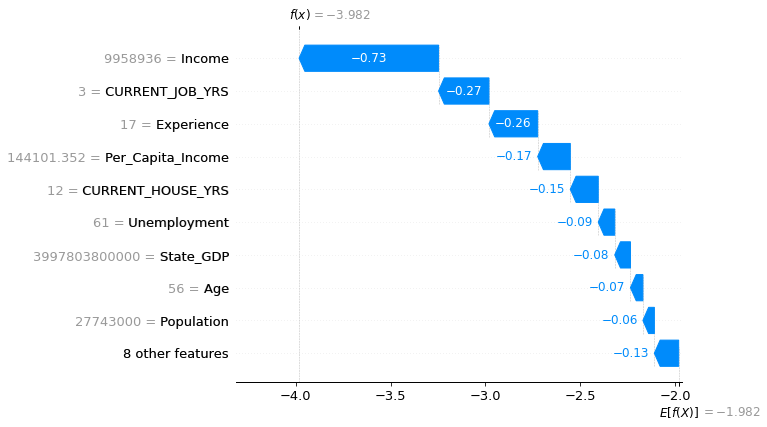

In [138]:
shap.plots.waterfall(shap_values[234595], max_display=10) # Risk Flag : 0

We can understand the Explainability at a deep dive level considering a specific case. 

The above explanation shows how each feature is contributing to the model output from the base value (the average model output E[f(X)] i.e. the expected value. 

The waterfall shap plot is explaining how each feature is impacting to the model output from the expected value. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

The base_value here is -1.982 while the predicted value is -2.247

In [229]:
results__train6_df.to_csv('Loan_prediction_Results6.csv', index = False)

In [230]:
results__train7_df.to_csv('Loan_prediction_Results7.csv', index = False)

# Hyperparameter Tuning XGBoost model iter-2 to improve model performance

In [108]:
import xgboost as xgb
model4 = xgb.XGBClassifier(learning_rate = 0.1,alpha = 10, random_state=0)
model4.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

In [117]:
params = {'learning_rate' : [0.05,0.10],'max_depth' : [5, 6, 7, 8],'min_child_weight' : [1, 3, 5],'gamma': [ 0.1, 1 , 10],'scale_pos_weight' : [2, 5, 10 , 20, 30] }
from sklearn.model_selection import RandomizedSearchCV
rs_model=RandomizedSearchCV(model4,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=1)

In [118]:
rs_model.fit(X_train, y_train)
rs_model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'scale_pos_weight': 30,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 1}

In [123]:
rs_model.best_estimator_

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

**Running model with best parameters and best estimators**

In [126]:
import xgboost as xgb
model6 = xgb.XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,colsample_bylevel=1, 
                           colsample_bynode=1, colsample_bytree=1,early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',importance_type=None, 
                           interaction_constraints='',learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,max_delta_step=0, 
                           max_depth=8, max_leaves=0, min_child_weight=1,monotone_constraints='()', n_estimators=100,n_jobs=0, 
                           num_parallel_tree=1, predictor='auto', random_state=0,reg_alpha=10,scale_pos_weight=30)
model6.fit(X_train, y_train)
y_pred_xgbc2 = model6.predict_proba(X_test)
y_train_xgbc2 = model6.predict_proba(X_train)

In [127]:
import sklearn.metrics as metrics
results_train10=[]
for i in range(0,101):
    y_pred = y_pred_xgbc2[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train10.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train10_df = pd.DataFrame(results_train10,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train10_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.879126,0.527767
1,0.01,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.879126,0.527767
2,0.02,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.879126,0.527767
3,0.03,6140,44236,1,23,0.121883,0.999837,0.217280,0.933277,0.879126,0.527767
4,0.04,6140,44229,1,30,0.121900,0.999837,0.217307,0.933287,0.879126,0.527767
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,244,88,5897,44171,0.734940,0.039733,0.075390,0.040109,0.879126,0.527767
97,0.97,57,20,6084,44239,0.740260,0.009282,0.018334,0.009374,0.879126,0.527767
98,0.98,8,1,6133,44258,0.888889,0.001303,0.002602,0.001316,0.879126,0.527767
99,0.99,0,0,6141,44259,0.000000,0.000000,0.000000,0.000000,0.879126,0.527767


In [128]:
import sklearn.metrics as metrics
results_train11=[]
for i in range(0,101):
    y_pred = y_train_xgbc2[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train11.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train11_df = pd.DataFrame(results_train11,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train11_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.924597,0.579963
1,0.01,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.924597,0.579963
2,0.02,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.924597,0.579963
3,0.03,24855,176653,0,92,0.123345,1.000000,0.219603,0.934257,0.924597,0.579963
4,0.04,24855,176616,0,129,0.123368,1.000000,0.219639,0.934269,0.924597,0.579963
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,1051,406,23804,176339,0.721345,0.042285,0.079888,0.042683,0.924597,0.579963
97,0.97,254,69,24601,176676,0.786378,0.010219,0.020176,0.010320,0.924597,0.579963
98,0.98,46,18,24809,176727,0.718750,0.001851,0.003692,0.001869,0.924597,0.579963
99,0.99,0,0,24855,176745,0.000000,0.000000,0.000000,0.000000,0.924597,0.579963


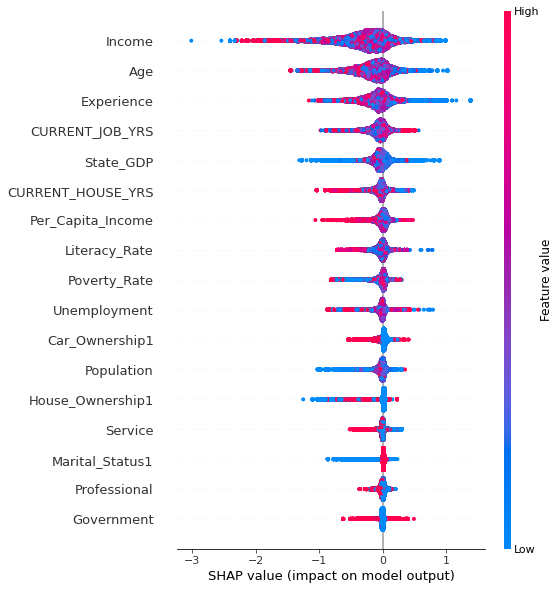

In [129]:
import shap
explainer = shap.TreeExplainer(model6)
shap_values = explainer.shap_values(X_train)
shap_val_df4 = pd.DataFrame(shap_values,columns=X_train.columns)
shap.summary_plot(shap_val_df4[X_train.columns].values,X_train,max_display=33)

Post hypertuning, model performance has improved, however let us figure out one more iteration with hypertuning using optuna

In [164]:
import xgboost as xgb
import sklearn.metrics as metrics
import optuna


def objective(trial):
    params = {'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,1),
              'max_depth' : trial.suggest_int('max_depth',5, 9),
              'min_child_weight' : trial.suggest_int('min_child_weight',1, 10),
              'gamma': trial.suggest_loguniform('gamma',1e-8, 1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',10, 40)}
    model6 = xgb.XGBClassifier(**params)
    model6.fit(X_train, y_train)
    y_pred = model6.predict(X_test)
    auc = metrics.roc_auc_score(y_test, y_pred)
    return auc

In [165]:
study = optuna.create_study(direction='maximize')

[I 2023-02-25 18:57:09,144] A new study created in memory with name: no-name-fdb92e17-b2e3-4103-acc7-d2f3f3b47821


In [166]:
study.optimize(objective, n_trials=100)

[I 2023-02-25 18:57:36,646] Trial 0 finished with value: 0.7164526264784612 and parameters: {'learning_rate': 0.06376072230749473, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 2.4223624616032386e-06, 'scale_pos_weight': 17}. Best is trial 0 with value: 0.7164526264784612.
[I 2023-02-25 18:57:52,128] Trial 1 finished with value: 0.7209923096352064 and parameters: {'learning_rate': 0.1856477622733756, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.0028031300856622924, 'scale_pos_weight': 20}. Best is trial 1 with value: 0.7209923096352064.
[I 2023-02-25 18:58:14,938] Trial 2 finished with value: 0.5385756951191499 and parameters: {'learning_rate': 0.01838708571389367, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 3.6060472588072297e-07, 'scale_pos_weight': 40}. Best is trial 1 with value: 0.7209923096352064.
[I 2023-02-25 18:58:33,541] Trial 3 finished with value: 0.8226287190140136 and parameters: {'learning_rate': 0.3040722369790981, 'max_depth': 8, 'min_child_weight': 2, 'gam

In [157]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8634076208137222
  Params: 
    learning_rate: 0.8924489922390481
    max_depth: 8
    min_child_weight: 10
    gamma: 0.11694770488109014
    scale_pos_weight: 29


Running model with best estimators as per optuna

In [118]:
import xgboost as xgb
model7 = xgb.XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,colsample_bylevel=1, 
                           colsample_bynode=1, colsample_bytree=1,early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, gamma=0.11694770488109014, gpu_id=-1, grow_policy='depthwise',importance_type=None, 
                           interaction_constraints='',learning_rate=0.8924489922390481, max_bin=256, max_cat_to_onehot=4,max_delta_step=0, 
                           max_depth=8, max_leaves=0, min_child_weight=10,monotone_constraints='()', n_estimators=100,n_jobs=0, 
                           num_parallel_tree=1, predictor='auto', random_state=0,reg_alpha=10,scale_pos_weight=29)
model7.fit(X_train, y_train)
y_pred_xgbc3 = model7.predict_proba(X_test)
y_train_xgbc3 = model7.predict_proba(X_train)
y_pred1_xgbc3 = model7.predict(X_test)

In [112]:
import sklearn.metrics as metrics
results_train11=[]
for i in range(0,101):
    y_pred = y_pred_xgbc3[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    recall = metrics.recall_score(y_test, y_hat)
    precision = metrics.precision_score(y_test, y_hat)
    accuracy = metrics.accuracy_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_test, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_test, y_pred)
    au_prc = metrics.average_precision_score(y_test, y_pred)
    results_train11.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train11_df = pd.DataFrame(results_train11,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train11_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,6141,44259,0,0,0.121845,1.000000,0.217223,0.933395,0.903244,0.550923
1,0.01,6004,35777,137,8482,0.143702,0.977691,0.250574,0.924564,0.903244,0.550923
2,0.02,5950,30251,191,14008,0.164360,0.968898,0.281045,0.924111,0.903244,0.550923
3,0.03,5917,26172,224,18087,0.184393,0.963524,0.309547,0.924833,0.903244,0.550923
4,0.04,5879,22492,262,21767,0.207219,0.957336,0.340693,0.924211,0.903244,0.550923
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,3551,2729,2590,41530,0.565446,0.578245,0.571774,0.578115,0.903244,0.550923
97,0.97,2786,1924,3355,42335,0.591507,0.453672,0.513501,0.454721,0.903244,0.550923
98,0.98,1469,828,4672,43431,0.639530,0.239212,0.348187,0.240704,0.903244,0.550923
99,0.99,327,189,5814,44070,0.633721,0.053249,0.098242,0.053736,0.903244,0.550923


In [113]:
import sklearn.metrics as metrics
results_train12=[]
for i in range(0,101):
    y_pred = y_train_xgbc3[:,1]
    y_hat = [1 if pred >= i/100 else 0 for pred in y_pred]
    tn, fp, fn, tp = metrics.confusion_matrix(y_train, y_hat).ravel()
    recall = metrics.recall_score(y_train, y_hat)
    precision = metrics.precision_score(y_train, y_hat)
    accuracy = metrics.accuracy_score(y_train, y_hat)
    f1 = metrics.f1_score(y_train, y_hat)
    f1_beta_10 = metrics.fbeta_score(y_train, y_hat, beta=10)
    auc = metrics.roc_auc_score(y_train, y_pred)
    au_prc = metrics.average_precision_score(y_train, y_pred)
    results_train12.append([i/100, tp, fp, fn, tn, precision, recall, f1, f1_beta_10, auc, au_prc])

    
print('\nSaved Diagnostincs: ')
results__train12_df = pd.DataFrame(results_train12,columns = ['level', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'f1_beta_10', 'auc', 'au_prc'])
display(results__train12_df)


Saved Diagnostincs: 


,level,tp,fp,fn,tn,precision,recall,f1,f1_beta_10,auc,au_prc
0,0.00,24855,176745,0,0,0.123289,1.000000,0.219514,0.934225,0.959286,0.676194
1,0.01,24855,141816,0,34929,0.149126,1.000000,0.259547,0.946528,0.959286,0.676194
2,0.02,24855,119348,0,57397,0.172361,1.000000,0.294041,0.954615,0.959286,0.676194
3,0.03,24855,102408,0,74337,0.195304,1.000000,0.326786,0.960805,0.959286,0.676194
4,0.04,24855,87492,0,89253,0.221234,1.000000,0.362313,0.966321,0.959286,0.676194
...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,16595,9598,8260,167147,0.633566,0.667673,0.650172,0.667317,0.959286,0.676194
97,0.97,13001,6553,11854,170192,0.664877,0.523074,0.585512,0.524181,0.959286,0.676194
98,0.98,6673,2558,18182,174187,0.722890,0.268477,0.391539,0.270159,0.959286,0.676194
99,0.99,1592,400,23263,176345,0.799197,0.064051,0.118598,0.064640,0.959286,0.676194


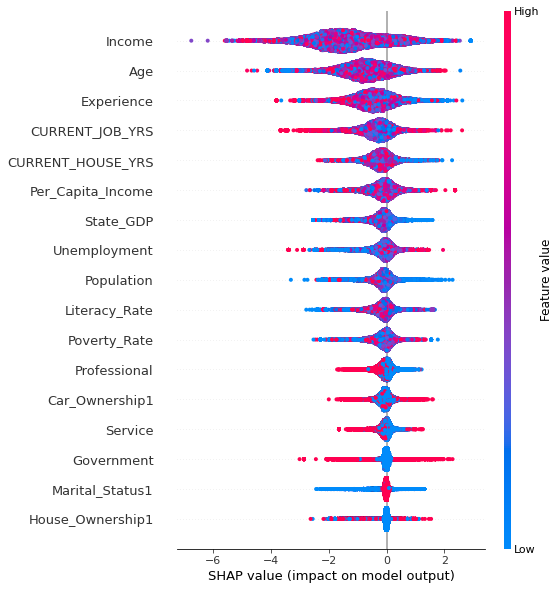

In [143]:
import shap
explainer = shap.TreeExplainer(model7)
shap_values = explainer.shap_values(X_train)
shap_val_df5 = pd.DataFrame(shap_values,columns=X_train.columns)
shap.summary_plot(shap_val_df5[X_train.columns].values,X_train,max_display=33)

# > Interpretability using LIME (Local Interpretable Model-Agnostic Explanations)

1) LIME focuses on training local surrogate models to explain individual predictions.

2) Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. 

3) Instead of training a global surrogate model, LIME focuses on training local surrogate models.

4) LIME is model-agnostic - it can be applied to any machine learning model. The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.

Importing Lime and creating explainer

In [143]:
import lime
import lime.lime_tabular

In [146]:
predict_rf = lambda x : model4.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns,
                                                  class_names=['Risk_Flag 0', 'Risk_Flag 1'], verbose=True, mode='classification')

In [140]:
test = final_loan_df
test.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,State_GDP,Literacy_Rate,Population,Unemployment,Poverty_Rate,Per_Capita_Income,Marital_Status1,Car_Ownership1,House_Ownership1,Central,Eastern,Northern,Southern,Western,Government,Professional,Service
0,1303834,23,3,3,13,0,5645143700000,75.37,72627000,47,31.65,77727.893208,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7574516,40,10,9,13,0,18893066600000,94.00,112374000,65,17.35,168126.671650,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3991815,66,4,4,10,0,5143999900000,66.41,33406000,116,7.05,153984.311202,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,6256451,41,2,2,12,1,3814703300000,74.43,41974000,78,32.59,90882.529661,1,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5768871,47,11,3,14,1,12455951500000,75.84,72147000,58,11.28,172646.839092,1,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


**Checking for specific instances**

In [141]:
test.loc[2406]   # Actual value from the original dataset

Income               2.499276e+06
Age                  2.100000e+01
Experience           0.000000e+00
CURRENT_JOB_YRS      0.000000e+00
CURRENT_HOUSE_YRS    1.200000e+01
Risk_Flag            1.000000e+00
State_GDP            2.189621e+12
Literacy_Rate        8.280000e+01
Population           3.298800e+07
Unemployment         9.300000e+01
Poverty_Rate         3.696000e+01
Per_Capita_Income    6.637629e+04
Marital_Status1      1.000000e+00
Car_Ownership1       0.000000e+00
House_Ownership1     1.000000e+00
Central              0.000000e+00
Eastern              1.000000e+00
Northern             0.000000e+00
Southern             0.000000e+00
Western              0.000000e+00
Government           0.000000e+00
Professional         1.000000e+00
Service              0.000000e+00
Name: 2406, dtype: float64

In [151]:
j = 2406
exp = explainer.explain_instance(X.values[j], predict_rf, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.07659295641463204
Prediction_local [0.17575803]
Right: 0.705496072769165


Label encoding values for categorical columns (as computed by the model)

1) Marital Status : Single 1 ; Married 0

2) Car ownership : No 0 ; Yes 1

Given weightage for House Ownership

1) House_weightage = {'norent_noown': 0, 'rented': 1, 'owned': 2}

In [148]:
test.loc[217449]  # Actual value from the original dataset

Income               9.625611e+06
Age                  4.000000e+01
Experience           1.800000e+01
CURRENT_JOB_YRS      9.000000e+00
CURRENT_HOUSE_YRS    1.200000e+01
Risk_Flag            1.000000e+00
State_GDP            3.857282e+12
Literacy_Rate        6.180000e+01
Population           1.040990e+08
Unemployment         9.600000e+01
Poverty_Rate         3.374000e+01
Per_Capita_Income    3.705398e+04
Marital_Status1      0.000000e+00
Car_Ownership1       0.000000e+00
House_Ownership1     1.000000e+00
Central              0.000000e+00
Eastern              1.000000e+00
Northern             0.000000e+00
Southern             0.000000e+00
Western              0.000000e+00
Government           0.000000e+00
Professional         1.000000e+00
Service              0.000000e+00
Name: 217449, dtype: float64

In [150]:
j = 217449
exp = explainer.explain_instance(X.values[j], predict_rf, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.10106645034316518
Prediction_local [0.12073271]
Right: 0.027501549571752548
